In [1]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import os 
import math
import sys
from pathlib import Path
import seaborn as sns

# Add 'src' to the system path
sys.path.append(str(Path().resolve() / 'src'))
from src.data.process_data import *
from src.data.clean_data import *
from src.utils.data_utils import *
from src.utils.plot_utils import *
from src.models.lda_model import *

[nltk_data] Downloading package stopwords to /Users/chsce/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
%run src/data/process_data.py
%run src/utils/data_utils.py
%run src/utils/plot_utils.py
%run src/models/lda_model.py

[nltk_data] Downloading package stopwords to /Users/chsce/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


IMPORTANT: these scripts/functions assume you have the following files in the data/raw directory:
- From the CMU dataset: 
    - movie.metadata.tsv
    - plot_summaries.txt
- From the TMDB dataset: 
    - TMDB_movie_dataset_v11.csv

AND have data/processed folder created

Note: download CMU dataset here: https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
and TMDB dataset here (Download button): https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies

In [2]:
# from raw files, creates clean datafiles
%run src/data/clean_data.py

Loading data from data/raw/TMDB_movie_dataset_v11.csv...
original df shape (1127777, 24)
after status (1102507, 24)
after adult (997822, 24)
after release date (669758, 24)
after release year (669758, 25)
after runtime (456959, 25)
after duplicates (453229, 25)
after numeric columns (453229, 25)
after select columns (453229, 13)
Loading data from data/raw/movie.metadata.tsv...
original df shape (81740, 9)
after release year (44006, 9)
after runtime (34490, 9)
after duplicates (34435, 9)
after numeric columns (34435, 9)
after select columns (34435, 5)
Loading data from data/raw/plot_summaries.txt...


In [2]:
# from clean data files, creates a dataframe with TMDB movies 
df = create_tmdb_dataset('data/processed/TMDB_clean.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 361971 entries, 0 to 453228
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   title                 361970 non-null  object
 1   release_date          361971 non-null  object
 2   revenue               361971 non-null  int64 
 3   runtime               361971 non-null  int64 
 4   budget                361971 non-null  int64 
 5   original_language     361971 non-null  object
 6   overview              361971 non-null  object
 7   genres                361971 non-null  object
 8   production_companies  361971 non-null  object
 9   production_countries  361971 non-null  object
 10  spoken_languages      361971 non-null  object
 11  keywords              361971 non-null  object
 12  release_year          361971 non-null  int64 
 13  dvd_era               361971 non-null  object
dtypes: int64(4), object(10)
memory usage: 41.4+ MB


In [4]:
df.head()

,title,release_date,revenue,runtime,budget,original_language,overview,genres,production_companies,production_countries,spoken_languages,keywords,release_year,dvd_era
0,Inception,2010-07-15,825532764,148,160000000,en,"Cobb, a skilled thief who commits corporate es...","[Action, Science Fiction, Adventure]","[Legendary Pictures, Syncopy, Warner Bros. Pic...","[United Kingdom, United States of America]","[English, French, Japanese, Swahili]","[rescue, mission, dream, airplane, paris, fran...",2010,post
1,Interstellar,2014-11-05,701729206,169,165000000,en,The adventures of a group of explorers who mak...,"[Adventure, Drama, Science Fiction]","[Legendary Pictures, Syncopy, Lynda Obst Produ...","[United Kingdom, United States of America]",[English],"[rescue, future, spacecraft, race against time...",2014,post
2,The Dark Knight,2008-07-16,1004558444,152,185000000,en,Batman raises the stakes in his war on crime. ...,"[Drama, Action, Crime, Thriller]","[DC Comics, Legendary Pictures, Syncopy, Isobe...","[United Kingdom, United States of America]","[English, Mandarin]","[joker, sadism, chaos, secret identity, crime ...",2008,post
3,Avatar,2009-12-15,2923706026,162,237000000,en,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[Dune Entertainment, Lightstorm Entertainment,...","[United States of America, United Kingdom]","[English, Spanish]","[future, society, culture clash, space travel,...",2009,post
4,The Avengers,2012-04-25,1518815515,143,220000000,en,When an unexpected enemy emerges and threatens...,"[Science Fiction, Action, Adventure]",[Marvel Studios],[United States of America],"[English, Hindi, Russian]","[new york city, superhero, shield, based on co...",2012,post


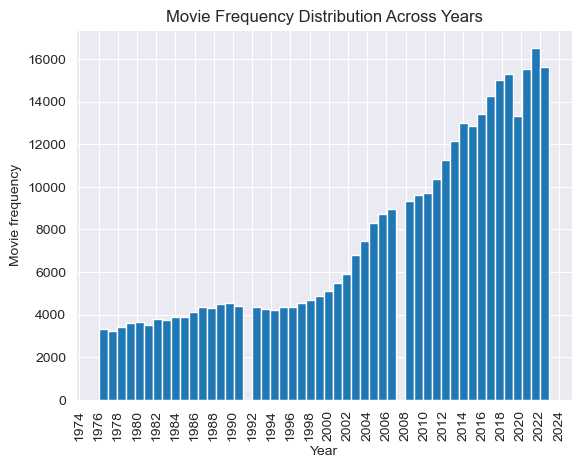

In [5]:
# Get a general distribution of movies
plt.hist(df['release_year'], bins=50)
plt.locator_params(axis='x', nbins=50) 
plt.xticks(rotation=90)
plt.xlabel('Year')
plt.ylabel('Movie frequency')
plt.title('Movie Frequency Distribution Across Years')
plt.show()

# Revenue overview
We first want to get an overview of movie revenue 

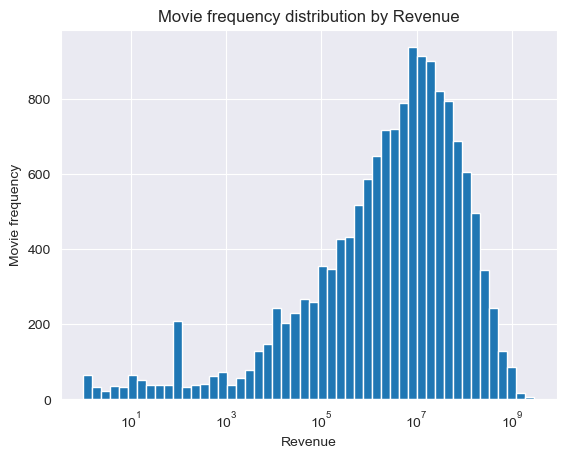

In [6]:
# Frequency distribution per budget, with budget in logscale 
plot_loghist(df[df['revenue'] > 0]['revenue'], 50, xlabel='Revenue', ylabel='Movie frequency')

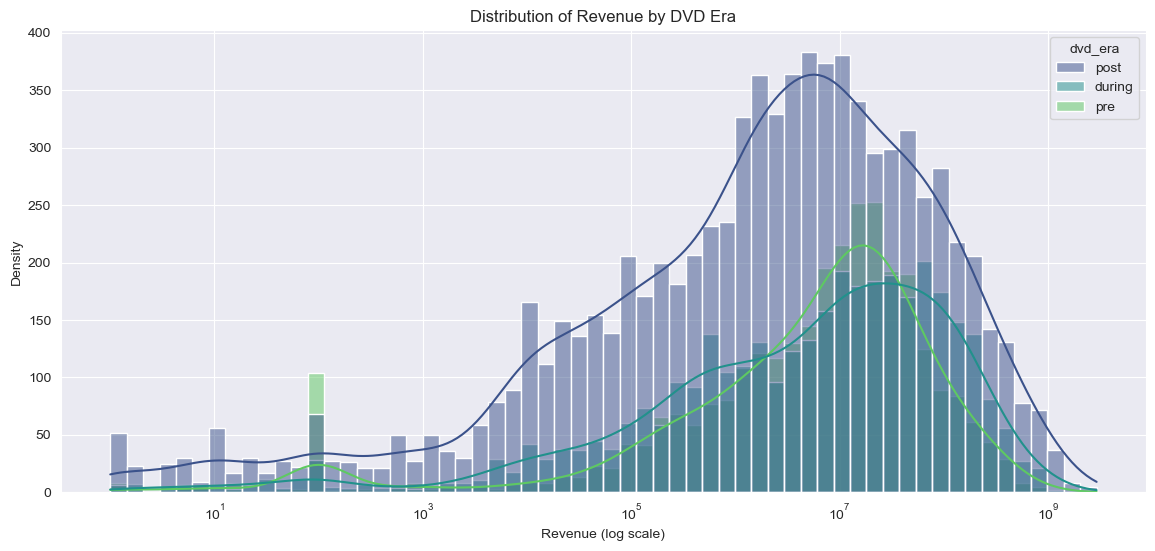

In [7]:
# Revenue per era
plot_revenue_per_era(df)

In [8]:
# Summary statistics for each DVD era
print('Summary statistics of revenue for each DVD era:')
df[df.revenue > 0].groupby('dvd_era')['revenue'].describe().reindex(['pre', 'during', 'post']).transpose()

Summary statistics of revenue for each DVD era:


dvd_era,pre,during,post
count,3.076000e+03,3.576000e+03,8.386000e+03
mean,3.272585e+07,5.088406e+07,4.996428e+07
std,7.217945e+07,1.160229e+08,1.539861e+08
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.222952e+06,5.630190e+05,1.516108e+05
50%,8.930740e+06,8.364978e+06,2.910307e+06
75%,2.921021e+07,4.821442e+07,2.488930e+07
max,9.201000e+08,2.264162e+09,2.923706e+09


TODO: add DVD rental sales plots from Yann

# Budget overview
## Budget trends

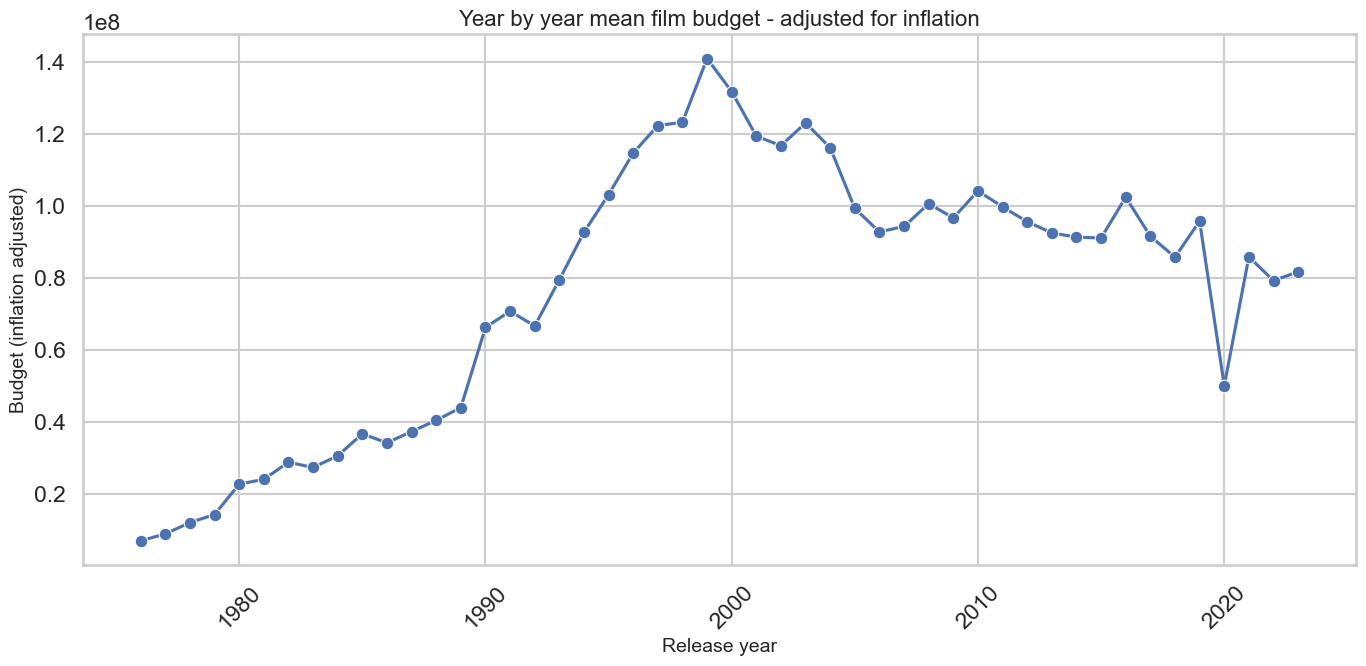

In [9]:
plot_mean_budget_inflation(df)

## Budget histograms

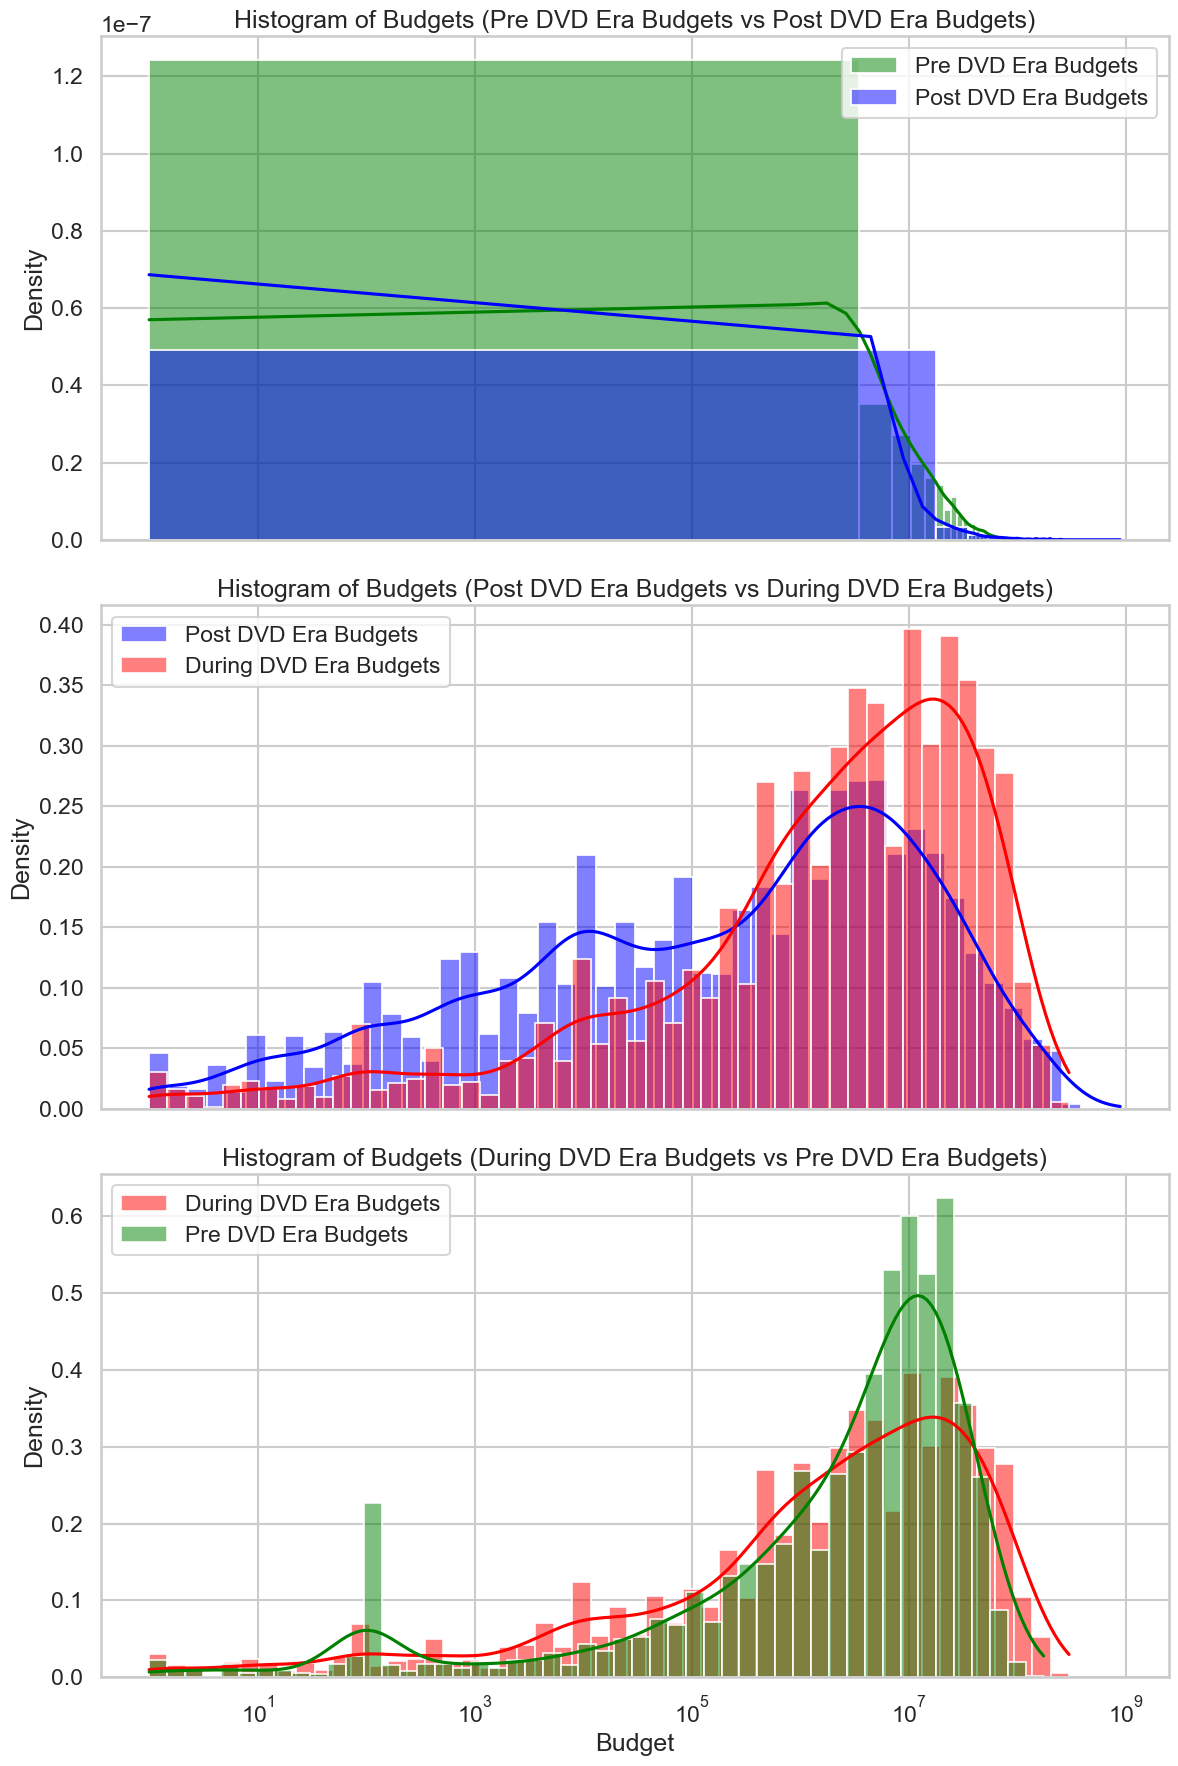

In [19]:
df_filtered = df[(df['budget'] > 0)]

# Define eras, colors, and labels for the plots
eras = [("pre", "post"), ("post", "during"), ("during", "pre")]
colors = [('green', 'blue'), ('blue', 'red'), ('red', 'green')]
labels = [('Pre DVD Era Budgets', 'Post DVD Era Budgets'), 
          ('Post DVD Era Budgets', 'During DVD Era Budgets'), 
          ('During DVD Era Budgets', 'Pre DVD Era Budgets')]

# Plot histograms
plot_budget_histograms(df_filtered, eras, colors, labels, 'Histogram of Budgets')

## Production types

/Users/chsce/Documents/ada-2024-project-databand/src/utils/data_utils.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'budget_category'] = df.apply(categorize_budget, args=(budget_stats,), axis=1)


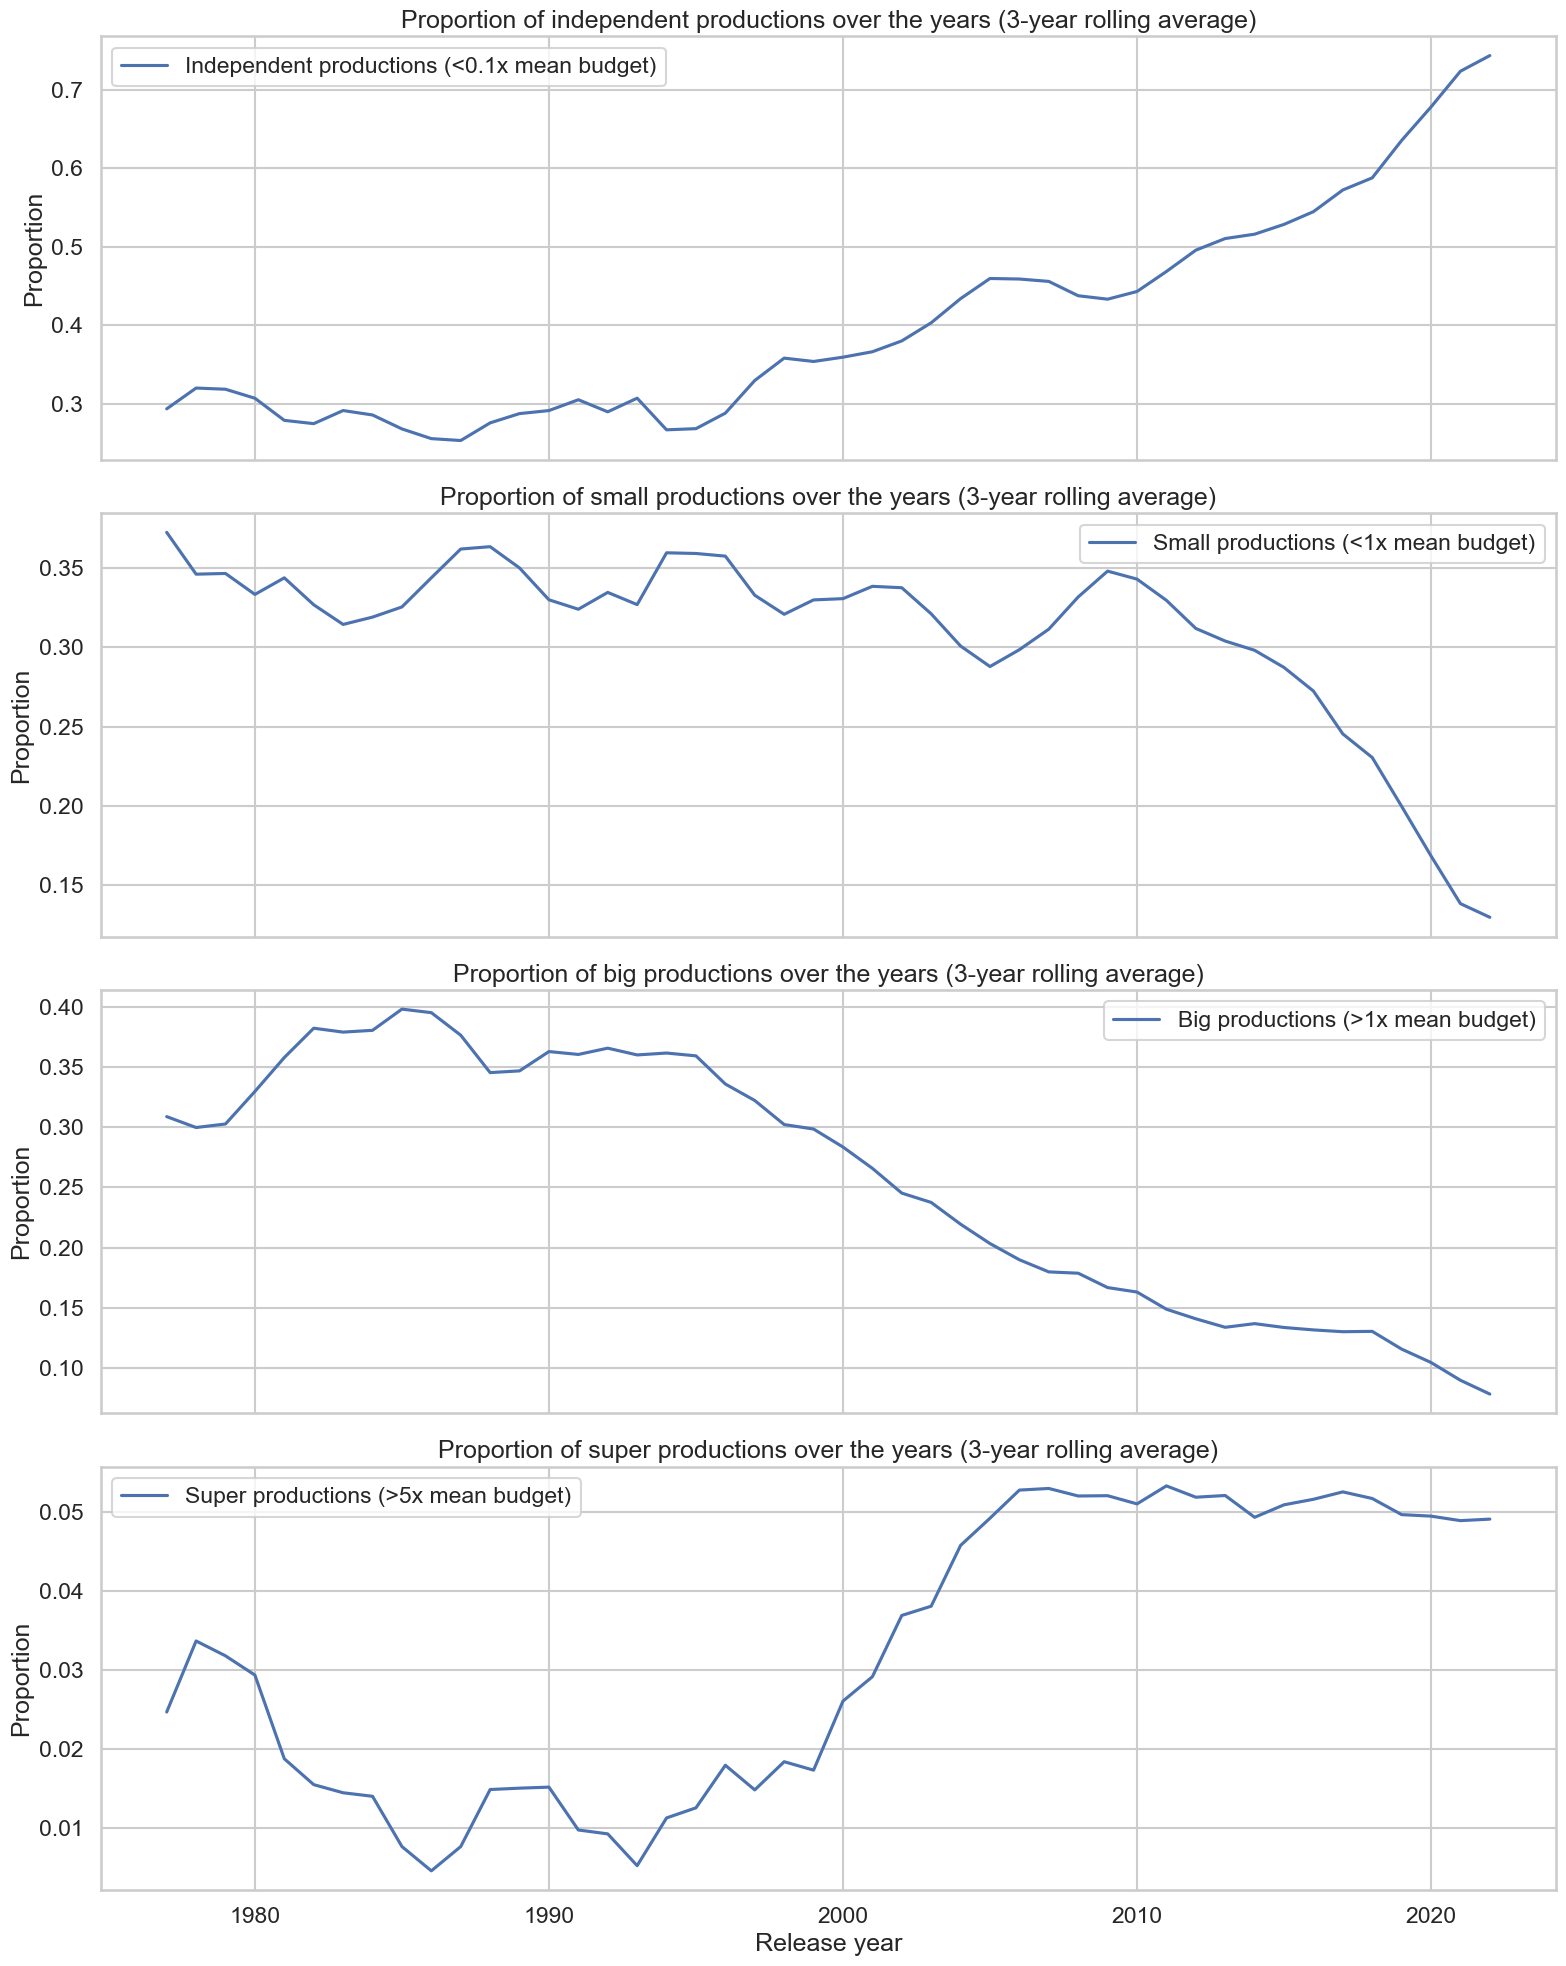

In [20]:
prop_rolling_avg = budget_rolling_averages(df_filtered, window=3)
plot_rolling_averages(prop_rolling_avg)

# Productions overview

# Runtime overview


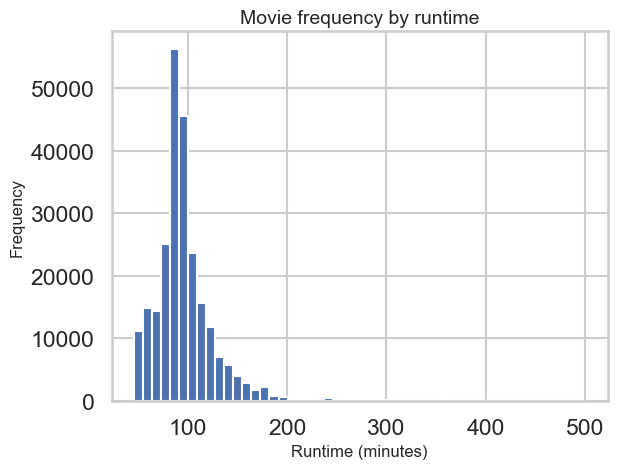

In [23]:
# General runtime distribution
plt.hist(df[(df['runtime'] > 0)]['runtime'], bins=50)
plt.xlabel('Runtime (minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Movie frequency by runtime', fontsize=14)
plt.show()

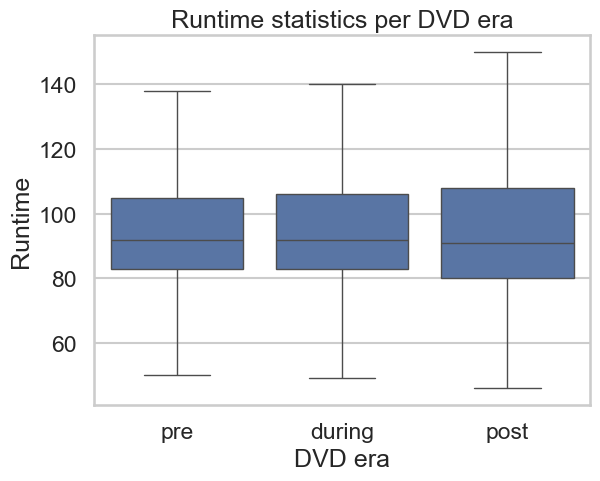

In [25]:
# Runtime statistics in boxplot 
sns.boxplot(x='dvd_era', y='runtime', data=df[df['runtime'] > 0], showfliers=False, order=['pre', 'during', 'post'])
plt.xlabel('DVD era')
plt.ylabel('Runtime')
plt.title('Runtime statistics per DVD era')
plt.show()

# Genre overview
For each DVD era, we obtain the top-10 movie genres based on the proportion of movies.


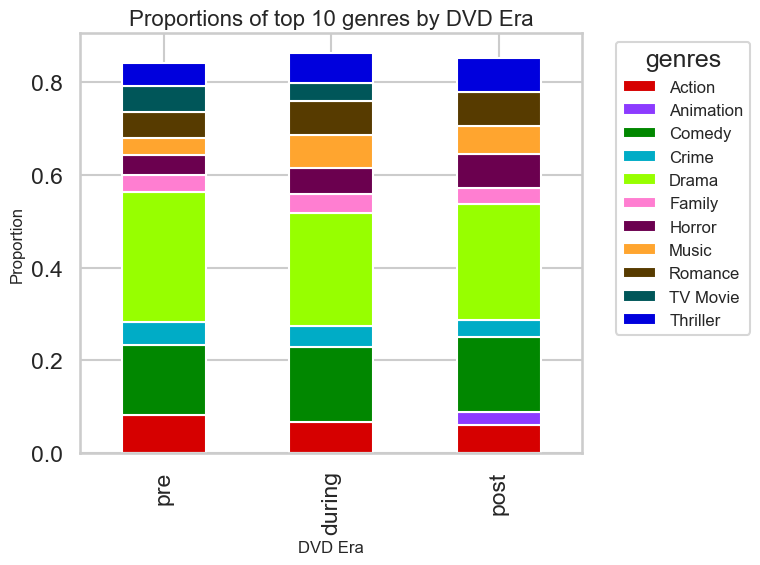

In [14]:
top_10_genre =top_proportions_per_era(df, 'genres', 10, True)
plot_top_proportions_per_era(top_10_genre, 'genres', 10)

# Theme extraction

For the major genres, we use LDA to extract the main topics in movies of the genre, with the goal of checking whether the main topics change overtime. Here is an example of topic extraction for the Drama movie genre, which appears to be the most common genre in the plot above. 

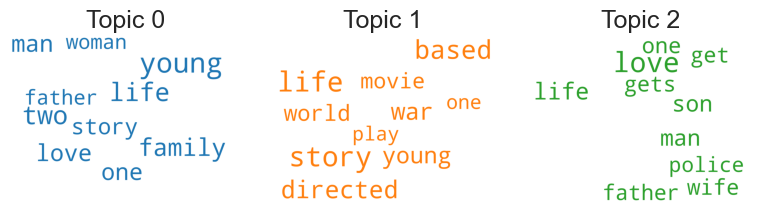

In [15]:
# Pre-process movie plots, lowercase, removing stopwords & special characters
df['clean_overview'] = df.overview.apply(clean_text)

# Extract plots for Drama genre and pre-DVD era
text_data = get_movie_plots(df, 'Drama', 'pre')
# Extract 3 main topics 
model = LDAModel(text_data, 3)
model.train()
model.plot_topics()

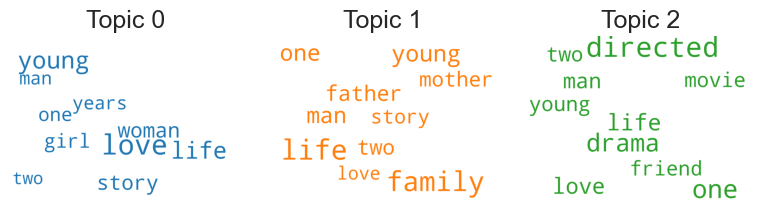

In [16]:
text_data = get_movie_plots(df, 'Drama', 'during')
model = LDAModel(text_data, 3)
model.train()
model.plot_topics()

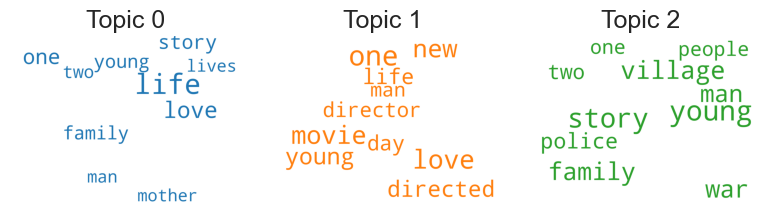

In [17]:
text_data = get_movie_plots(df, 'Drama', 'post')
model = LDAModel(text_data, 3)
model.train()
model.plot_topics()